In [1]:
# Importing necessary packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [2]:
# Getting rid of warnings

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Data Import

path = "/Users/markarshavsky/Desktop/ML/Project/"
institutions = pd.read_csv(path + "/Most-Recent-Cohorts-Institution.csv", low_memory = False)
schools_by_state = pd.read_excel(path + "/schools_by_state.xlsx")

In [4]:
# Selecting best-documented variables

institutions_df = institutions[['UNITID','INSTNM','ADM_RATE','SAT_AVG','PCTPELL','STABBR','CONTROL','HCM2','UGDS','UGDS_BLACK','UGDS_HISP','UGDS_ASIAN','FIRST_GEN','FEMALE',\
    'COSTT4_A','TUITIONFEE_IN','TUITIONFEE_OUT','MD_FAMINC','C150_4','C150_L4','NPT4_PUB','NPT4_PRIV','WDRAW_ORIG_YR2_RT',\
    'DEBT_MDN','RPY_1YR_RT','HIGHDEG','PREDDEG','MD_EARN_WNE_1YR','MD_EARN_WNE_5YR','MD_EARN_WNE_P10']]

In [5]:
# Filtering institutions where INSTNM is in df['School']

institutions_df = institutions_df[institutions_df['INSTNM'].isin(schools_by_state['School'])]

In [6]:
# Compiling 'COMP_ALL' and 'COST_ALL' variables

institutions_df['COMP_ALL'] = institutions_df['C150_4'].fillna(institutions_df['C150_L4'])
institutions_df.drop(columns=['C150_4', 'C150_L4'], inplace=True)

institutions_df['COST_ALL'] = institutions_df['NPT4_PRIV'].fillna(institutions_df['NPT4_PUB'])
institutions_df.drop(columns=['NPT4_PUB', 'NPT4_PRIV'], inplace=True)

In [7]:
# Defining binary outcome (5yr)

median_5yr = institutions_df['MD_EARN_WNE_5YR'].median()
institutions_df['high_earn_5yr']  = (institutions_df['MD_EARN_WNE_5YR'] >= median_5yr).astype(int)

In [8]:
# Selecting feature and target lists

# 1) Continuous
cont = ['COST_ALL','ADM_RATE','SAT_AVG','PCTPELL','COMP_ALL']

# 2) Categoricals
cat = ['CONTROL','HIGHDEG']

# 3). Targets 
target = ['high_earn_5yr']

In [9]:
# Dropping NA's + Creating dummies

df_clean = institutions_df.dropna(subset = cont + cat + target)
df_dummies = pd.get_dummies(df_clean[cat], drop_first=True)

In [10]:
# Extracting X and y_5yr

X = pd.concat([df_clean[cont], df_dummies], axis=1)
y_5yr = df_clean['high_earn_5yr'].values

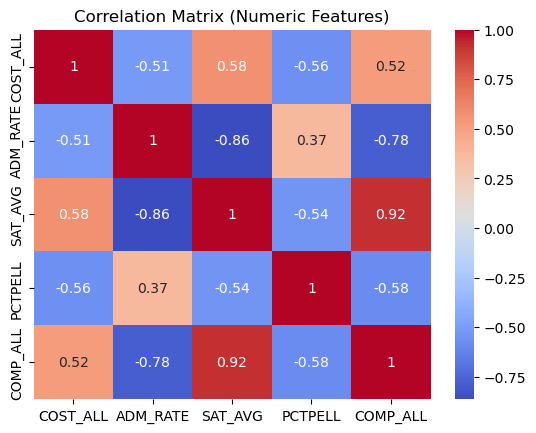

In [11]:
# Correlation Heat-Map

sns.heatmap(df_clean[cont].corr(), annot = True, cmap = 'coolwarm')
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

In [12]:
# Splitting into train and test (5yr)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_5yr,
    test_size=0.2,
    random_state=123
)

# Imputing missing values

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scaling features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [13]:
# LDA (5yr)

lda_fit = LDA().fit(X_train_scaled, y_train)
lda_est = lda_fit.predict(X_test_scaled)
misclassification_error = np.mean(lda_est != y_test)
print("LDA misclassification error (5yr):", misclassification_error)

LDA misclassification error (5yr): 0.1


In [14]:
# QDA (5yr)

qda_fit = QDA().fit(X_train_scaled, y_train)
qda_est = qda_fit.predict(X_test_scaled)
misclassification_error = np.mean(qda_est != y_test)
print("QDA misclassification error (5yr):", misclassification_error)

QDA misclassification error (5yr): 0.2
